In [126]:
import graspy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
#uncomment when placed into model folder not doc
#from .base import BaseGraphEstimator, _calculate_p

from scipy.stats import bernoulli 
import pandas as pd 

from graspy.simulations import sbm, er_np, er_nm
from graspy.plot import heatmap

from graspy.models.base import BaseGraphEstimator 
from graspy.utils.utils import (
    augment_diagonal,
    cartprod,
    import_graph,
    is_unweighted,
    remove_loops,
    symmetrize,
)

%matplotlib inline

In [92]:
def siem(n, p,edge_comm, directed=False, loops=False, wt=None, wtargs=None):
    """
    Samples a graph from the structured independent edge model (SIEM) 
    SIEM produces a graph with specified communities, in which each community can
    have different sizes and edge probabilities. 
    Read more in the :ref:`tutorials <simulations_tutorials>`
    Parameters
    ----------
    n: int
        Number of vertices
    p: list of int of length K (k_communities)
        Probability of an edge existing within the corresponding communities, where p[i] indicates 
        the probability of an edge existing in the edge_comm[i]
    edge_comm: 2d list of K tuples (k_communities)
        tuple is the indices for the edge within the kth community.
    directed: boolean, optional (default=False)
        If False, output adjacency matrix will be symmetric. Otherwise, output adjacency
        matrix will be asymmetric.
    loops: boolean, optional (default=False)
        If False, no edges will be sampled in the diagonal. Otherwise, edges
        are sampled in the diagonal.
    wt: object or list of K objects (k_communities)
        if Wt is an object, a weight function to use globally over
        the siem for assigning weights. If Wt is a list, a weight function for each of
        the edge communities to use for connection strengths Wt[i] corresponds to the weight function
        for edge community i. Default of None results in a binary graph
    wtargs: dictionary or array-like, shape (k_communities)
        if Wt is an object, Wtargs corresponds to the trailing arguments
        to pass to the weight function. If Wt is an array-like, Wtargs[i, j] 
        corresponds to trailing arguments to pass to Wt[i, j].
    return_labels: boolean, optional (default = False)
        IF True, returns the edge-communities as well
    References
    ----------
    Returns
    -------
    A: ndarray, shape (sum(n), sum(n))
        Sampled adjacency matrix
    T: returns the edge-communities if return_labels == True
    Examples
    --------
    >>> np.random.seed(1)
    >>> n = [3, 3]
    >>> p = [[0.5, 0.1], [0.1, 0.5]]
    To sample a binary 2-block SBM graph:
    >>> sbm(n, p)
    array([[0., 0., 1., 0., 0., 0.],
           [0., 0., 1., 0., 0., 1.],
           [1., 1., 0., 0., 0., 0.],
           [0., 0., 0., 0., 1., 0.],
           [0., 0., 0., 1., 0., 0.],
           [0., 1., 0., 0., 0., 0.]])
    To sample a weighted 2-block SBM graph with Poisson(2) distribution:
    >>> wt = np.random.poisson
    >>> wtargs = dict(lam=2)
    >>> sbm(n, p, wt=wt, wtargs=wtargs)
    array([[0., 4., 0., 1., 0., 0.],
           [4., 0., 0., 0., 0., 2.],
           [0., 0., 0., 0., 0., 0.],
           [1., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 2., 0., 0., 0., 0.]])
    """
    # Check n
    if not isinstance(n, (int)):
        msg = "n must be a int, not {}.".format(type(n))
        raise TypeError(msg)
    # Check edge_comm 
    if not isinstance(edge_comm, (list)):
        msg = "edge_comm must be a 2d list of length k."
        raise TypeError(msg)
    else: 
        for i in range(len(edge_comm)):
            for x in edge_comm[i]:
                if not (len(x)==2 and isinstance (x,tuple)):
                    msg = "The edge_comm list must contain tuples of 2 elements."
                    raise TypeError(msg)
        #edge_comm = np.array(edge_comm)
        #generate temporary adjacency matrix to check upper triangular?
        if (directed == True) and (loops == True):
            if not(sum(len(x) for x in edge_comm) <= n**2) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n**2 !".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)
        elif (directed == True) and (loops == False): 
            if not(sum(len(x) for x in edge_comm) <= n*(n-1)/2): 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n(n-1)/2!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
        elif (directed == False) and (loops == True):
            #check symmetry ?
            if not(sum(len(x) for x in edge_comm) <= n*(n-1)) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n(n-1)!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
        elif (directed == False) and (loops == False): 
            #check symmetry ?
            if not(sum(len(x) for x in edge_comm) <= n**2/2) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n**2/2!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
    # Check p
    if not isinstance(p, (list, np.ndarray)):
        msg = "p must be a list or np.array, not {}.".format(type(p))
        raise TypeError(msg)
    else:
        p = np.array(p)
        if not np.issubdtype(p.dtype, np.number):
            msg = "There are non-numeric elements in p"
            raise ValueError(msg)
        elif np.any(p < 0) or np.any(p > 1):
            msg = "Values in p must be in between 0 and 1."
            raise ValueError(msg)
        elif len(p) != len(edge_comm):
            msg = "# of Probabilities and # of Communities Don't Match Up"
            raise ValueError(msg)
    # Check wt and wtargs
    if (wt is not None) and (wtargs is not None): 
        if callable(wt):
            #extend the function to size of k 
            wt = np.full(len(edge_comm), wt, dtype=object)
            wtargs = np.full(len(edge_comm), wtargs, dtype=object)
        elif type(wt) == list:
            if all(callable(x) for x in wt): 
                # if not object, check dimensions
                if len(wt) != (len(edge_comm)):
                    msg = "wt must have size k, not {}".format(len(wt))
                    raise ValueError(msg)
                if len(wtargs) != (len(edge_comm)):
                    msg = "wtargs must have size k , not {}".format(len(wtargs))
                    raise ValueError(msg)
                # check if each element is a function
                for element in wt.ravel():
                    if not callable(element):
                        msg = "{} is not a callable function.".format(element)
                        raise TypeError(msg)   
            else: 
                msg = "list must contain all callable objects"
                raise ValueError(msg)
        else:
            msg = "wt must be a callable object or list of callable objects"
            raise ValueError(msg)

    K = len(edge_comm) # the number of communities
    # End Checks, begin simulation
    A = np.zeros((n,n))

    # list of lists of 2-d tuples version
    for i in range(0, K):
        #sample bernoulli at once
        rvs = bernoulli.rvs(p[i],size = len(edge_comm[i]))
        #iterate over each index
        for x in range(len(edge_comm[i])):
            #set each equal to bernoulli 
            A[edge_comm[i][x]] = rvs[x]
            #adjust adjacency matrix with any weight args. 
            if (wt is not None) and (wtargs is not None): 
                    A[edge_comm[i][x]] = A[edge_comm[i][x]]*wt[i](**wtargs[i])
    
    if not directed:
        A = A + A.T - np.diag(A)
        
    return A


In [93]:
siem_test = SIEMEstimator(directed = True, loops = False)

In [107]:

def generate_samples(n,pq,wt = None,wtargs = None,plot = True):
    #n is number of vertices 
    #pq is true population matrix values [[p,q],[q,p]]
    m = int(n/2)
    if (wt == None) and (wtargs == None): 
        g = sbm(n = [m,m], p =pq)
    else:
        g = sbm(n = [m,m], p =pq, wt= wt,wtargs = wtargs)
    if plot:
        heatmap(g)
    #on diagonal p
    edge_comm_p = np.concatenate((np.argwhere(g[:m,:m] != 0),(np.argwhere(g[m:,m:] != 0) + m)),axis = 0) 
    #off diagnonal q
    edge_comm_q = np.concatenate(( (np.argwhere(g[m:,:m] != 0) + [m,0]),(np.argwhere(g[:m,m:] != 0) + [0,m]) ) ,axis = 0) 
    
    comms = [edge_comm_p,edge_comm_q]
    edge_comm = []
    for i in comms:
        edge_comm_list = []
        for x in range(len(i)):
            edge_comm_list.append(tuple(i[x]))
        edge_comm.append(edge_comm_list)
    
    return edge_comm

def test_probabilities(sample_data,n_k,p):
    #sample_data is dictionary of sampled data
    #n_k k array of edges in community k
    #p is k array of true probability means. 
    
    for i in range(len(p)):
        print('Sample Prob: ' + str(len(sample_data[i])/n_k[i] )   )
        print('True Population Prob: ' + str(p[i]))
    

### Test 1: Base Case Check SIEM grabs proper edges as given for Unweighted

Sample Prob: 0.5148
True Population Prob: 0.5
Sample Prob: 0.1
True Population Prob: 0.1


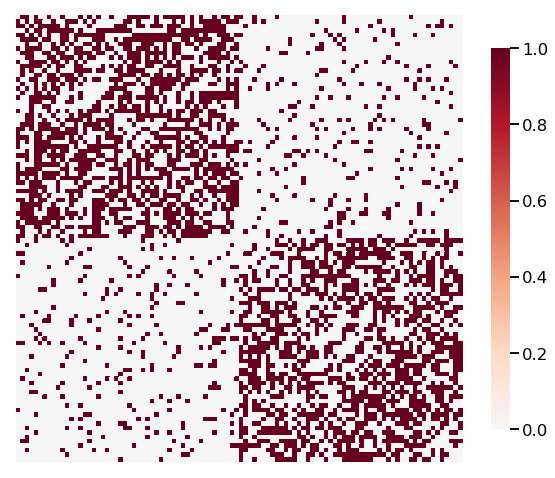

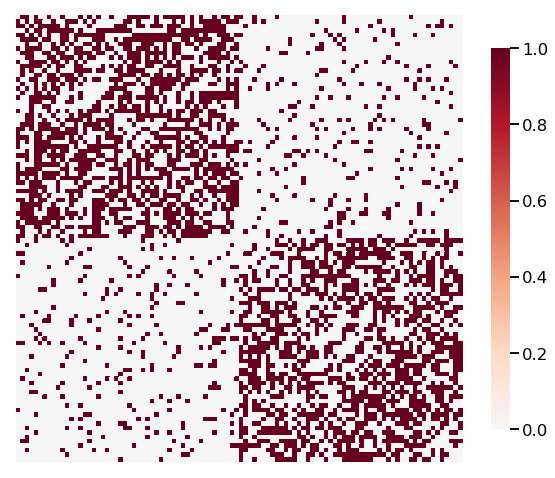

In [95]:
# p = 0.1 community
n = 100
edge_comm = generate_samples(n,[[0.5,0.1],[0.1,0.5]])

p = [1,1]
s1 = siem(n = n, p=p, directed = True, loops = False, edge_comm = edge_comm)
heatmap(s1)

siem_test = SIEMEstimator()
siem_test.fit(s1,edge_comm = edge_comm, weighted = False)
model_dict = siem_test.model
test_probabilities(model_dict,[50*50*2,50*50*2],p = [0.5,0.1])


In [96]:
### Test 1: Base Case Check SIEM grabs proper edges as given for Weighted

Graph is weighted!
[[ 0.          0.44879809  0.         ...  0.          0.
   0.        ]
 [-0.07949557  0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.53548912]
 ...
 [ 0.          0.          0.         ...  0.          1.5412562
   0.        ]
 [ 0.          0.          0.         ...  0.28538039  0.
   0.08047593]
 [ 0.          0.         -0.1624899  ...  0.          0.86677977
   0.        ]]
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 0]]
Sample Prob: 0.4892
True Population Prob: 0.5
Sample Prob: 0.0996
True Population Prob: 0.1


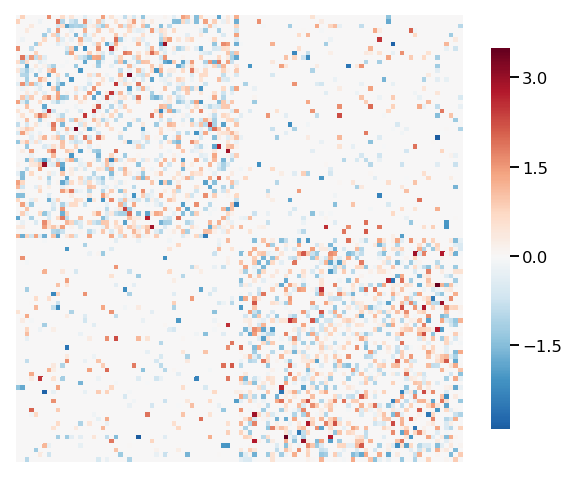

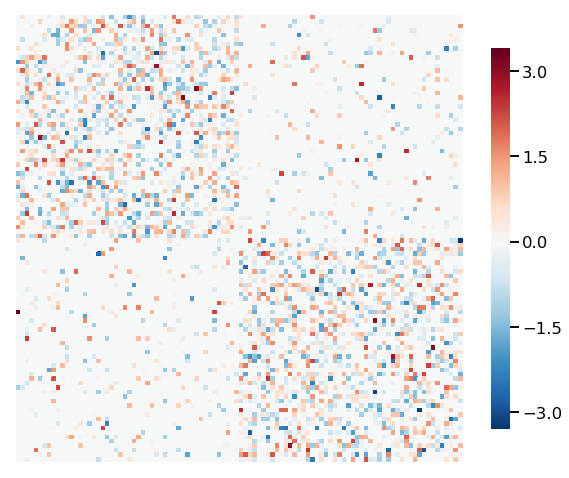

In [99]:
# p = 0.1 community
n = 100
wt = np.random.normal
wtargs = dict(loc=0, scale=1)

edge_comm = generate_samples(n,[[0.5,0.1],[0.1,0.5]],wt= wt, wtargs = wtargs)

p = [1,1]
s1 = siem(n = n, p=p, directed = True, loops = False, edge_comm = edge_comm, wt = wt, wtargs = wtargs)
heatmap(s1)

siem_test = SIEMEstimator()
siem_test.fit(s1,edge_comm = edge_comm, weighted = 0.0)
model_dict = siem_test.model
test_probabilities(model_dict,[50*50*2,50*50*2],p = [0.5,0.1])

### Unweighted N Increment Sample Testing

In [130]:
x_p = []
y_p = []
e_p = []

x_q = []
y_q = []
e_q = []


for n in range(10,500,10):
    
    # p = 0.1 community
    p_true = [0.5,0.1]
    edge_comm = generate_samples(n,[[0.5,0.1],[0.1,0.5]],plot = False)

    p = [1,1]
    s1 = siem(n = n, p=p, directed = True, loops = False, edge_comm = edge_comm)
#     heatmap(s1)

    siem_test = SIEMEstimator()
    siem_test.fit(s1,edge_comm = edge_comm, weighted = False)
    sample_data = siem_test.model
    n_k = [n/2*n/2*2,n/2*n/2*2]
    print('N = ' + str(n))
    for i in range(len(p_true)):
        print('Sample Prob: ' + str(len(sample_data[i])/n_k[i] ))
        print('True Population Prob: ' + str(p_true[i]))
    
    x_p.append(n)
    x_q.append(n)
    y_p.append(len(sample_data[0])/n_k[i])
    y_q.append(len(sample_data[1])/n_k[i])

prob_p = np.repeat(0.5,len(x_p))
prob_q = np.repeat(0.1,len(x_p))

e_p = y_p - prob_p
e_q = y_q - prob_q



N = 10
Sample Prob: 0.4
True Population Prob: 0.5
Sample Prob: 0.0
True Population Prob: 0.1
N = 20
Sample Prob: 0.41
True Population Prob: 0.5
Sample Prob: 0.11
True Population Prob: 0.1
N = 30
Sample Prob: 0.49777777777777776
True Population Prob: 0.5
Sample Prob: 0.12
True Population Prob: 0.1
N = 40
Sample Prob: 0.4825
True Population Prob: 0.5
Sample Prob: 0.0875
True Population Prob: 0.1
N = 50
Sample Prob: 0.5216
True Population Prob: 0.5
Sample Prob: 0.0752
True Population Prob: 0.1
N = 60
Sample Prob: 0.4888888888888889
True Population Prob: 0.5
Sample Prob: 0.10666666666666667
True Population Prob: 0.1
N = 70
Sample Prob: 0.506938775510204
True Population Prob: 0.5
Sample Prob: 0.08816326530612245
True Population Prob: 0.1
N = 80
Sample Prob: 0.4875
True Population Prob: 0.5
Sample Prob: 0.10875
True Population Prob: 0.1
N = 90
Sample Prob: 0.497283950617284
True Population Prob: 0.5
Sample Prob: 0.09925925925925926
True Population Prob: 0.1
N = 100
Sample Prob: 0.4928
True P

Text(0, 0.5, 'Probability')

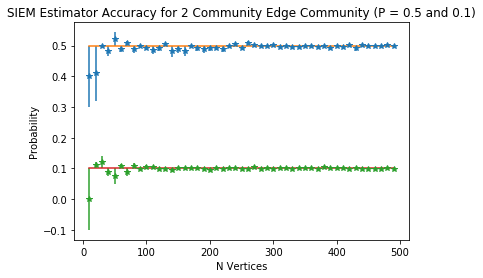

In [131]:
plt.figure()
plt.errorbar(x_p,y_p,e_p,linestyle='None', marker = '*')
plt.plot(x_p,np.repeat(0.5,len(x_p)))

plt.errorbar(x_q,y_q,e_q,linestyle='None', marker = '*')
plt.plot(x_p,np.repeat(0.1,len(x_q)))

plt.title('SIEM Estimator Accuracy for 2 Edge Community (P = 0.5 and 0.1)')
plt.xlabel('N Vertices')
plt.ylabel('Probability')

Text(0, 0.5, 'Mean Squared Error')

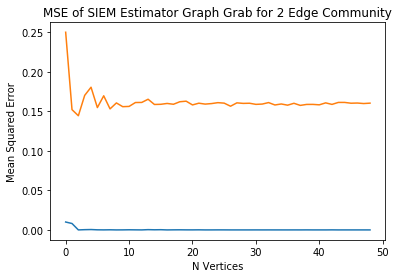

In [134]:
mse_p = (y_p - prob_p)**2

mse_q = (y_q - prob_p)**2

plt.figure()

plt.plot(mse_p)
plt.plot(mse_q)
plt.title('MSE of SIEM Estimator Graph Grab for 2 Edge Community')
plt.xlabel('N Vertices')
plt.ylabel('Mean Squared Error')